# Project Code 

## Import Main Modules

In [1]:
from __future__ import print_function
import argparse
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
# imports used by the resnet implementation
from torch.nn import init
import math

## Import Datasets

In [2]:
# Initial parameters
dataset = 'cifar10'
batch_size = 64
epochs = 10
lr = 0.01

Comment: We can also do it on MNIST dataset

In [3]:
# Data Loading
# This cell might take some time when you run it for the first time
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)
elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified


In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images[0].shape # image size

torch.Size([3, 32, 32])

## View Datasets

In [5]:
# Design the function to show an image
import matplotlib.pyplot as plt

def imshow(img):
    """function to show an image"""
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
# classes of images
if dataset == 'mnist':
    classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
elif dataset == 'cifar10':
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

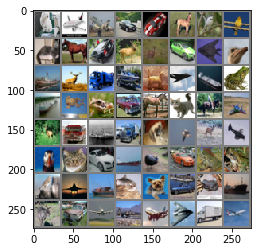

Label is as follows:
   dog plane plane   car   car horse  bird  bird
   cat horse   car  deer  deer   car plane  bird
  ship  deer truck  ship   cat plane  ship  frog
  ship  frog  frog   car horse   cat horse plane
  deer truck  ship truck   dog  bird  deer plane
  bird   cat   car  ship  bird   car  frog  frog
  bird plane  ship   cat   dog   car  frog  ship
  deer   car plane plane plane plane truck plane



In [7]:
# This cell can give us a better understanding of dataset.
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
plt.show()
# print labels
print('Label is as follows:')
print(' ' + ' '.join('%5s' % classes[labels[j]] if (j + 1) % 8 != 0 else '%5s' % classes[labels[j]] + '\n' for j in range(len(labels)) ))

## Define Neural Networks

### Single Layer Network with Linear Transformations

In [9]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784 # number of input
elif dataset == 'cifar10':
    num_inputs = 3072 # number of input

num_outputs = 10 # number of output, the same for both mnist and cifar10 datasets

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        # print(input.shape)
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        output = output
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [10]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval() 
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [11]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.365305
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.782508
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.772463
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.932725
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.821323
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.802516
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.854338
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.890429

Test set: Average loss: 1.7789, Accuracy: 3839/10000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.785598
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.662673
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.636844
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.774476
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.045124
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.766758
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.817403
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.836288

Test set: Average loss: 1.7448, Accuracy: 3989/10000 (40%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.639829
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.665

### Two Layer Network with Linear Transformations

In [12]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs
num_hiddens = num_inputs # To prepare for residue network

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hiddens)
        self.fc2 = nn.Linear(num_hiddens, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        hidden = self.fc1(input)
        output = self.fc2(F.tanh(hidden))
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [13]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval() 
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [14]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.328527
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.918596
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.914238
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.980046
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.774175
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.822827
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.655791
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.728971

Test set: Average loss: 1.7700, Accuracy: 3870/10000 (39%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.815831
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.806710
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.819750
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.754139
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.381035
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.513029
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.888826
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.683622

Test set: Average loss: 1.7363, Accuracy: 3983/10000 (40%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.732063
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.662

### One Layer ResNet with Linear Transformations

In [15]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs
num_hiddens = num_inputs # To prepare for residue network

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hiddens)
        self.fc2 = nn.Linear(num_hiddens, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        hidden = self.fc1(input) + input # Residue part
        output = self.fc2(F.tanh(hidden))
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [16]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval() 
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [17]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.304604
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.872725
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.887975
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.669505
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.757973
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.976917
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.869448
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.695397

Test set: Average loss: 1.7598, Accuracy: 3869/10000 (39%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.854672
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.836346
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.586532
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.528037
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.806559
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.562513
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.745626
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.558773

Test set: Average loss: 1.7100, Accuracy: 4072/10000 (41%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.778471
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.749

### One Layer ResNet with Activation Functions

In [18]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs
num_hiddens = num_inputs # To prepare for residue network

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hiddens)
        self.fc2 = nn.Linear(num_hiddens, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        hidden = F.relu(self.fc1(input)) + input # Residue part
        output = self.fc2(F.tanh(hidden))
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [19]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval() 
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [20]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.359092
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.951125
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.861476
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.593782
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.939704
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.787285
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.722223
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.800961

Test set: Average loss: 1.6760, Accuracy: 4177/10000 (42%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.804432
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.707805
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.763523
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.332678
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.634637
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.595577
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.536187
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.640916

Test set: Average loss: 1.6054, Accuracy: 4394/10000 (44%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.449031
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.356

### One Layer Convolutional ResNet with Activation Functions

In [31]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs
num_hiddens = num_inputs # To prepare for residue network

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hiddens)
        self.fc2 = nn.Linear(num_hiddens, num_outputs)
        self.conv = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, input):
        # input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        hidden = F.relu(self.conv(input)) + input # Residue part
        hidden = hidden.view(-1, num_hiddens)
        output = self.fc2(F.tanh(hidden))
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [32]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval() 
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [33]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.343016
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.938352
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.697794
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.792659
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.772689
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.683789
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.819510
Train Epoch: 1 [44800/50000 (90%)]	Loss: 2.020418

Test set: Average loss: 1.7191, Accuracy: 4071/10000 (41%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.745724
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.891966
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.656613
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.654277
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.700070
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.779191
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.607825
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.920474

Test set: Average loss: 1.6820, Accuracy: 4159/10000 (42%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.529215
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.673

### Three Layer Convolutional Network

In [44]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs
num_hiddens = num_inputs # To prepare for residue network

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(3, 3, kernel_size = 5, stride=1, padding=2)
        self.fc1 = nn.Linear(num_inputs, num_hiddens)
        self.fc2 = nn.Linear(num_hiddens, num_outputs)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, input):
        out = F.tanh(self.conv1(input)) # Residue part
        out = F.tanh(self.conv2(out))
        out = out.view(-1, num_inputs) # reshape input to batch x num_inputs
        out = F.tanh(self.fc1(out))
        output = self.fc2(out)
        # output = self.fc2(F.tanh(out))
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [45]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval() 
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [46]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.304411
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.206069
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.968199
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.881027
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.018491
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.855460
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.818585
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.738160

Test set: Average loss: 1.7610, Accuracy: 3795/10000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.937292
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.812229
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.747871
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.628088
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.888902
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.619740
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.696236
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.693753

Test set: Average loss: 1.6823, Accuracy: 4141/10000 (41%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.641963
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.510

## ResNet Implementation by Kaiming He

### Basic block

In [ ]:
class ResNetBasicblock(nn.Module):
  expansion = 1
  """
  RexNet basicblock (https://github.com/facebook/fb.resnet.torch/blob/master/models/resnet.lua)
  """
  def __init__(self, inplanes, planes, stride=1, downsample=None):
    super(ResNetBasicblock, self).__init__()

    self.conv_a = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn_a = nn.BatchNorm2d(planes)

    self.conv_b = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn_b = nn.BatchNorm2d(planes)

    self.downsample = downsample

  def forward(self, x):
    residual = x

    basicblock = self.conv_a(x)
    basicblock = self.bn_a(basicblock)
    basicblock = F.relu(basicblock, inplace=True)

    basicblock = self.conv_b(basicblock)
    basicblock = self.bn_b(basicblock)

    if self.downsample is not None:
      residual = self.downsample(x)
    
    return F.relu(residual + basicblock, inplace=True)

### ResNet for CIFAR

In [ ]:
class CifarResNet(nn.Module):
  """
  ResNet optimized for the Cifar dataset, as specified in
  https://arxiv.org/abs/1512.03385.pdf
  """
  def __init__(self, block, depth, num_classes):
    """ Constructor
    Args:
      depth: number of layers.
      num_classes: number of classes
      base_width: base width
    """
    super(CifarResNet, self).__init__()

    #Model type specifies number of layers for CIFAR-10 and CIFAR-100 model
    assert (depth - 2) % 6 == 0, 'depth should be one of 20, 32, 44, 56, 110'
    layer_blocks = (depth - 2) // 6
    print ('CifarResNet : Depth : {} , Layers for each block : {}'.format(depth, layer_blocks))

    self.num_classes = num_classes

    self.conv_1_3x3 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn_1 = nn.BatchNorm2d(16)

    self.inplanes = 16
    self.stage_1 = self._make_layer(block, 16, layer_blocks, 1)
    self.stage_2 = self._make_layer(block, 32, layer_blocks, 2)
    self.stage_3 = self._make_layer(block, 64, layer_blocks, 2)
    self.avgpool = nn.AvgPool2d(8)
    self.classifier = nn.Linear(64*block.expansion, num_classes)

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        #m.bias.data.zero_()
      elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
        init.kaiming_normal(m.weight)
        m.bias.data.zero_()

  def _make_layer(self, block, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes * block.expansion:
      downsample = DownsampleA(self.inplanes, planes * block.expansion, stride)

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample))
    self.inplanes = planes * block.expansion
    for i in range(1, blocks):
      layers.append(block(self.inplanes, planes))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv_1_3x3(x)
    x = F.relu(self.bn_1(x), inplace=True)
    x = self.stage_1(x)
    x = self.stage_2(x)
    x = self.stage_3(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    return self.classifier(x)

### Predefined Models of Different Depth

In [ ]:
def resnet20(num_classes=10):
  """Constructs a ResNet-20 model for CIFAR-10 (by default)
  Args:
    num_classes (uint): number of classes
  """
  model = CifarResNet(ResNetBasicblock, 20, num_classes)
  return model

def resnet32(num_classes=10):
  """Constructs a ResNet-32 model for CIFAR-10 (by default)
  Args:
    num_classes (uint): number of classes
  """
  model = CifarResNet(ResNetBasicblock, 32, num_classes)
  return model

def resnet44(num_classes=10):
  """Constructs a ResNet-44 model for CIFAR-10 (by default)
  Args:
    num_classes (uint): number of classes
  """
  model = CifarResNet(ResNetBasicblock, 44, num_classes)
  return model

def resnet56(num_classes=10):
  """Constructs a ResNet-56 model for CIFAR-10 (by default)
  Args:
    num_classes (uint): number of classes
  """
  model = CifarResNet(ResNetBasicblock, 56, num_classes)
  return model

def resnet110(num_classes=10):
  """Constructs a ResNet-110 model for CIFAR-10 (by default)
  Args:
    num_classes (uint): number of classes
  """
  model = CifarResNet(ResNetBasicblock, 110, num_classes)
  return model

### Code for Downsampling 

In [ ]:
class DownsampleA(nn.Module):  

  def __init__(self, nIn, nOut, stride):
    super(DownsampleA, self).__init__() 
    assert stride == 2    
    self.avg = nn.AvgPool2d(kernel_size=1, stride=stride)   

  def forward(self, x):   
    x = self.avg(x)  
    return torch.cat((x, x.mul(0)), 1)  

class DownsampleC(nn.Module):     

  def __init__(self, nIn, nOut, stride):
    super(DownsampleC, self).__init__()
    assert stride != 1 or nIn != nOut
    self.conv = nn.Conv2d(nIn, nOut, kernel_size=1, stride=stride, padding=0, bias=False)

  def forward(self, x):
    x = self.conv(x)
    return x

class DownsampleD(nn.Module):

  def __init__(self, nIn, nOut, stride):
    super(DownsampleD, self).__init__()
    assert stride == 2
    self.conv = nn.Conv2d(nIn, nOut, kernel_size=2, stride=stride, padding=0, bias=False)
    self.bn   = nn.BatchNorm2d(nOut)

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    return x

### Training on Predefined ResNet Models

In [ ]:
network = resnet20()
optimizer = optim.SGD(network.parameters(), lr=lr)

In [45]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval() 
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [46]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.304411
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.206069
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.968199
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.881027
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.018491
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.855460
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.818585
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.738160

Test set: Average loss: 1.7610, Accuracy: 3795/10000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.937292
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.812229
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.747871
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.628088
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.888902
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.619740
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.696236
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.693753

Test set: Average loss: 1.6823, Accuracy: 4141/10000 (41%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.641963
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.510